<a href="https://colab.research.google.com/github/AnnaAntAnEv/tax-optimization-ooo/blob/main/nalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Запуск программы - 2025-06-23 09:18:11



Saving Планируемые показатели.xlsx to Планируемые показатели (9).xlsx

Распознанные показатели:
Доходы: 12000000.0
Расходы: 6000000.0
Фот: 3000000.0
Сотрудники: 10

Рекомендация по системе налогообложения:
Система: УСН
Объект: Доходы
Ставка: 6%
Налог: 720000.0
Обоснование: УСН "Доходы" выгоднее при текущих показателях

Экономия по сравнению с УСН Доходы-Расходы: 180,000 руб. (20.0%)


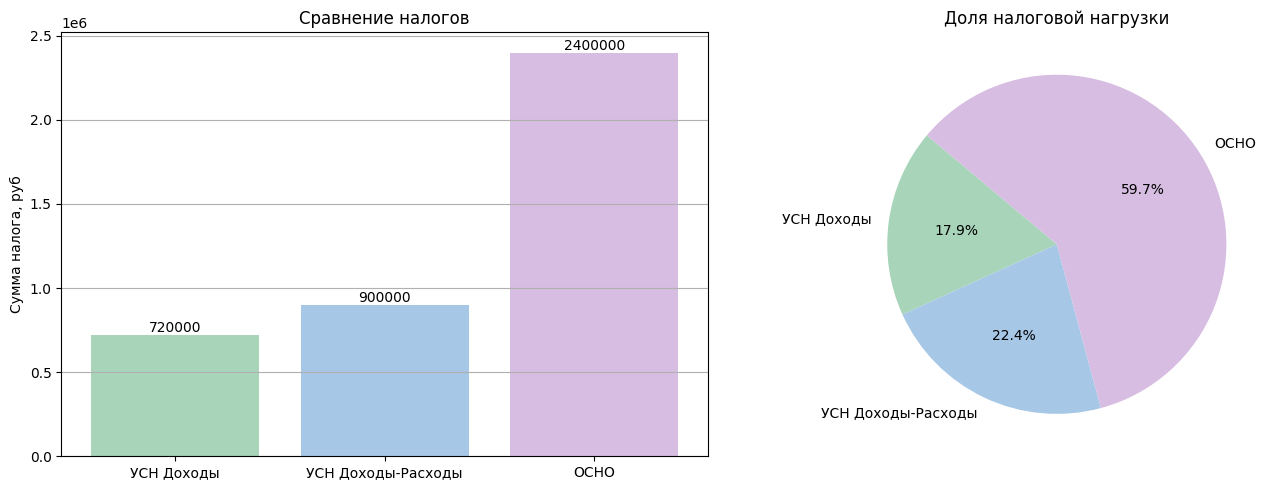

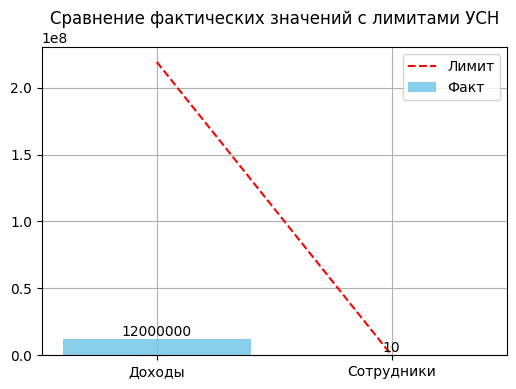


Анализ влияния роста доходов на налоги:


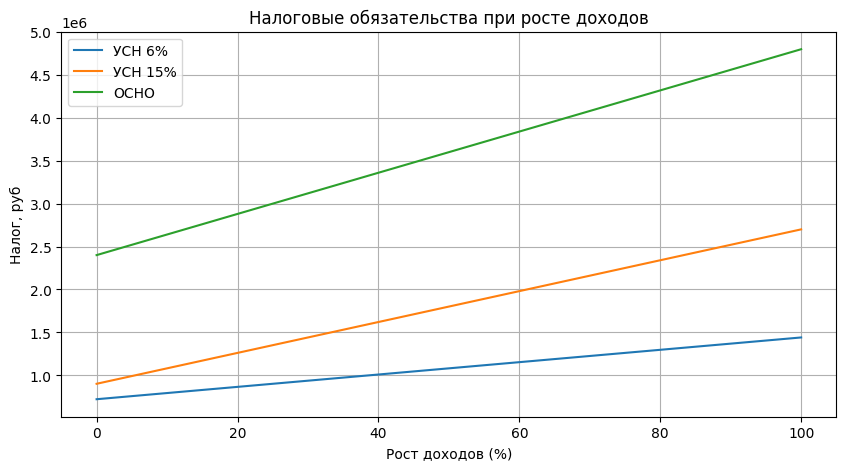


Корреляция между ростом доходов и налогами:
                Рост доходов %  УСН 6%  УСН 15%  ОСНО
Рост доходов %             1.0     1.0      1.0   1.0
УСН 6%                     1.0     1.0      1.0   1.0
УСН 15%                    1.0     1.0      1.0   1.0
ОСНО                       1.0     1.0      1.0   1.0


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files


def load_data():
    """
    Загружает данные из Excel-файла, нормализует и приводит к нужным типам.
    Возвращает pd.Series с ключевыми показателями.
    """
    uploaded = files.upload()
    if not uploaded:
        print("Файл не был загружен. Пожалуйста, попробуйте снова.")
        return None

    file_name = next(iter(uploaded))
    try:
        data = pd.read_excel(file_name, header=None, index_col=0)
        data.columns = ['value']
        metrics = data.squeeze()
        metrics.index = metrics.index.str.lower().str.strip()

        normalization_rules = {
            'доходы': ['доход', 'выручк', 'д)', 'д '],
            'расходы': ['расход', 'затрат', 'р)', 'р '],
            'фот': ['фонд оплат', 'фот', 'заработн', 'оплат труда'],
            'сотрудники': ['числен', 'работник', 'сотрудник', 'персонал', 'штат']
        }

        normalized_metrics = {}
        for std_name, patterns in normalization_rules.items():
            # Найти все индексы, где встречается хотя бы один из паттернов
            mask = metrics.index.map(lambda x: any(p in x for p in patterns))
            matched = metrics[mask]
            if not matched.empty:
                val = matched.iloc[0]
                try:
                    val = float(val)
                    if std_name == 'сотрудники':
                        val = int(val)
                    normalized_metrics[std_name.capitalize()] = val
                except ValueError:
                    print(f"Не удалось преобразовать значение для '{std_name}': {val}")

        print("\nРаспознанные показатели:")
        for k, v in normalized_metrics.items():
            print(f"{k}: {v}")

        # Проверяем обязательные поля и ставим 0, если отсутствуют
        required_fields = {'Доходы': 0, 'Расходы': 0, 'Сотрудники': 0}
        for field in required_fields:
            if field not in normalized_metrics:
                print(f"\nВнимание! Не найден показатель '{field}' в файле, будет использоваться 0.")
            else:
                required_fields[field] = normalized_metrics[field]

        return pd.Series(required_fields)

    except Exception as e:
        print(f"Ошибка при загрузке файла: {e}")
        return None


def calculate_taxes(data):
    """
    Рассчитывает суммы налогов по системам УСН (6% и 15%) и ОСНО.
    :param data: pd.Series с показателями 'Доходы', 'Расходы' и т.п.
    :return: dict с налогами по системам
    """
    if 'Доходы' not in data or data['Доходы'] == 0:
        print("Ошибка: Не указаны доходы или они равны нулю!")
        return None

    usn_income_tax = data['Доходы'] * 0.06

    if data.get('Расходы', 0) > 0:
        usn_income_expenses_tax = (data['Доходы'] - data['Расходы']) * 0.15
        minimal_tax = data['Доходы'] * 0.01
        usn_income_expenses_tax = max(usn_income_expenses_tax, minimal_tax)
    else:
        usn_income_expenses_tax = None

    osno_tax = data['Доходы'] * 0.2

    return {
        'УСН Доходы': usn_income_tax,
        'УСН Доходы-Расходы': usn_income_expenses_tax,
        'ОСНО': osno_tax
    }


def recommend_system(taxes, data):
    """
    Формирует рекомендацию по оптимальной системе налогообложения.
    :param taxes: dict с налогами по системам
    :param data: pd.Series с показателями
    :return: dict с рекомендацией и обоснованием
    """
    if taxes is None:
        return {'Система': 'ОСНО', 'Обоснование': 'Отсутствуют данные о доходах'}

    recommendations = []
    usn_available = True
    limits = {'Доходы': 219_200_000, 'Сотрудники': 130}

    if data.get('Доходы', 0) > limits['Доходы']:
        usn_available = False
        recommendations.append(f"Превышен лимит доходов для УСН ({limits['Доходы']:,} руб.)")

    if data.get('Сотрудники', 0) > limits['Сотрудники']:
        usn_available = False
        recommendations.append(f"Превышен лимит по сотрудникам для УСН ({limits['Сотрудники']} чел.)")

    if usn_available:
        if taxes['УСН Доходы-Расходы'] is not None:
            if taxes['УСН Доходы'] < taxes['УСН Доходы-Расходы']:
                best = ('УСН', 'Доходы', '6%', taxes['УСН Доходы'])
            else:
                best = ('УСН', 'Доходы минус расходы', '15%', taxes['УСН Доходы-Расходы'])
        else:
            best = ('УСН', 'Доходы', '6%', taxes['УСН Доходы'])

        if best[3] > taxes['ОСНО'] * 0.9:
            return {
                'Система': 'ОСНО',
                'Обоснование': f"ОСНО может быть выгоднее (~{taxes['ОСНО']:,.2f} руб. против {best[3]:,.2f} руб.)"
            }

        return {
            'Система': best[0],
            'Объект': best[1],
            'Ставка': best[2],
            'Налог': best[3],
            'Обоснование': f"{best[0]} \"{best[1]}\" выгоднее при текущих показателях"
        }

    return {
        'Система': 'ОСНО',
        'Обоснование': 'УСН недоступна. ' + ' '.join(recommendations)
    }


TAX_COLORS = {
    'УСН Доходы': '#A8D5BA',           # пастельный зелёный
    'УСН Доходы-Расходы': '#A7C7E7',   # пастельный голубой
    'ОСНО': '#D7BDE2'                  # пастельный сиреневый
}


def visualize(taxes):
    """
    Визуализация налогов: bar-chart и pie-chart.
    :param taxes: dict с налогами
    """
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    names = list(taxes.keys())
    values = [v if v is not None else 0 for v in taxes.values()]
    colors = [TAX_COLORS.get(name, '#9e9e9e') for name in names]
    bars = plt.bar(names, values, color=colors)
    plt.title("Сравнение налогов")
    plt.ylabel("Сумма налога, руб")
    plt.grid(True, axis='y')
    plt.bar_label(bars, fmt='%.0f')

    plt.subplot(1, 2, 2)
    filtered = {k: v for k, v in taxes.items() if v is not None and v > 0}
    pie_colors = [TAX_COLORS.get(name, '#9e9e9e') for name in filtered.keys()]
    plt.pie(filtered.values(), labels=filtered.keys(), colors=pie_colors,
            autopct='%1.1f%%', startangle=140)
    plt.title("Доля налоговой нагрузки")

    plt.tight_layout()
    plt.show()


def visualize_limits(data):
    """
    Визуализация сравнения доходов и численности с лимитами УСН.
    """
    limits = {'Доходы': 219_200_000, 'Сотрудники': 130}
    actual = {k: data.get(k, 0) for k in limits}

    plt.figure(figsize=(6, 4))
    bars = plt.bar(actual.keys(), actual.values(), color='skyblue', label='Факт')
    plt.plot(limits.keys(), limits.values(), 'r--', label='Лимит')
    plt.title("Сравнение фактических значений с лимитами УСН")
    plt.legend()
    plt.grid(True)
    plt.bar_label(bars, fmt='%.0f')
    plt.show()


def simulate_growth(data):
    """
    Анализ чувствительности налогов при росте доходов от 0% до 100%.
    """
    print("\nАнализ влияния роста доходов на налоги:")
    base_income = data['Доходы']
    growth_range = range(0, 110, 10)
    usn6_list, usn15_list, osno_list = [], [], []

    for percent in growth_range:
        new_income = base_income * (1 + percent / 100)
        temp_data = data.copy()
        temp_data['Доходы'] = new_income

        taxes = calculate_taxes(temp_data)
        usn6_list.append(taxes['УСН Доходы'])
        usn15_list.append(taxes['УСН Доходы-Расходы'] if taxes['УСН Доходы-Расходы'] is not None else 0)
        osno_list.append(taxes['ОСНО'])

    plt.figure(figsize=(10, 5))
    plt.plot(growth_range, usn6_list, label='УСН 6%')
    plt.plot(growth_range, usn15_list, label='УСН 15%')
    plt.plot(growth_range, osno_list, label='ОСНО')

    plt.title("Налоговые обязательства при росте доходов")
    plt.xlabel("Рост доходов (%)")
    plt.ylabel("Налог, руб")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Корреляция
    corr_df = pd.DataFrame({
        'Рост доходов %': list(growth_range),
        'УСН 6%': usn6_list,
        'УСН 15%': usn15_list,
        'ОСНО': osno_list
    })
    print("\nКорреляция между ростом доходов и налогами:")
    print(corr_df.corr().round(2))


def main():
    print(f"Запуск программы - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    data = load_data()
    if data is None:
        print("Ошибка загрузки данных. Завершение работы.")
        return

    taxes = calculate_taxes(data)
    if taxes is None:
        print("Не удалось рассчитать налоги. Завершение работы.")
        return

    recommendation = recommend_system(taxes, data)
    print("\nРекомендация по системе налогообложения:")
    for k, v in recommendation.items():
        print(f"{k}: {v}")

    # Выводим экономию по сравнению с второй лучшей системой
    valid_taxes = {k: v for k, v in taxes.items() if v is not None}
    sorted_taxes = sorted(valid_taxes.items(), key=lambda x: x[1])
    best_tax = sorted_taxes[0]
    if len(sorted_taxes) > 1:
        second_best_tax = sorted_taxes[1]
        economy = second_best_tax[1] - best_tax[1]
        economy_percent = (economy / second_best_tax[1]) * 100
        print(f"\nЭкономия по сравнению с {second_best_tax[0]}: {economy:,.0f} руб. ({economy_percent:.1f}%)")

    visualize(taxes)
    visualize_limits(data)
    simulate_growth(data)


if __name__ == "__main__":
    main()